#### Notice that this programm is executed on GPU. So we explicitly put data on GPU by calling ```.to(device)```

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


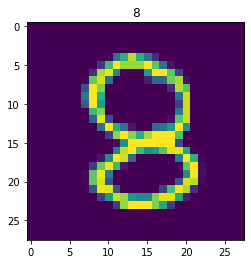

In [2]:
with np.load('./prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[0, 0])
plt.title(data_y[0])
plt.show()

In [3]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Define some constants
BATCH_SIZE = 500
LR = 0.001
EPOCHS = 10

In [6]:
# Transform np to tensor
torch_X_train = torch.tensor(X_train)
torch_y_train = torch.tensor(y_train)

torch_X_val = torch.tensor(X_val)
torch_y_val = torch.tensor(y_val)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
validate = torch.utils.data.TensorDataset(torch_X_val,torch_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(28*28, 320)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(320, 160)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(160, 80)
    self.relu3 = nn.ReLU()
    self.fc4 = nn.Linear(80, 40)
    self.relu4 = nn.ReLU()
    self.fc5 = nn.Linear(40, 20)
    self.relu5 = nn.ReLU()
    self.fc6 = nn.Linear(20, 10)

  def forward(self, x):
    x = self.relu1(self.fc1(x))
    x = self.relu2(self.fc2(x))
    x = self.relu3(self.fc3(x))
    x = self.relu4(self.fc4(x))
    x = self.relu5(self.fc5(x))
    x = self.fc6(x)
    return F.log_softmax(x, dim=1) 

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=320, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=320, out_features=160, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=160, out_features=80, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=80, out_features=40, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=40, out_features=20, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=20, out_features=10, bias=True)
)


In [9]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [10]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

In [11]:
def to_img(x):
  x = (x + 1.) * 0.5
  x = x.clamp(0, 1)
  x = x.view(1, 28, 28)
  return x

In [12]:
steps = len(train_loader)
lossList = [] 
testLostList = []
accuracy = [] 
label_list = []

In [13]:
for epoch in range(EPOCHS):
  # training
  model.train() 
  totalLoss = 0

  for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1, 28*28).to(device) 
    labels = labels.to(device)
    
    outputs = model(images)
    # predictions.append(outputs)
    loss = loss_criterion(outputs, labels)
    totalLoss = totalLoss + loss.item()
    
    # back propagation and update weights
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (i+1) % 5 == 0:
      print('Epoch [{}/{}] | Step [{}/{}] | Loss: {:.4f}'.format(epoch+1, EPOCHS, i+1, steps, totalLoss/(i+1)))

  lossList.append(totalLoss/(i+1))

Epoch [1/10] | Step [5/36] | Loss: 2.1247
Epoch [1/10] | Step [10/36] | Loss: 1.6619
Epoch [1/10] | Step [15/36] | Loss: 1.3684
Epoch [1/10] | Step [20/36] | Loss: 1.1701
Epoch [1/10] | Step [25/36] | Loss: 1.0266
Epoch [1/10] | Step [30/36] | Loss: 0.9183
Epoch [1/10] | Step [35/36] | Loss: 0.8416
Epoch [2/10] | Step [5/36] | Loss: 0.2335
Epoch [2/10] | Step [10/36] | Loss: 0.2378
Epoch [2/10] | Step [15/36] | Loss: 0.2431
Epoch [2/10] | Step [20/36] | Loss: 0.2373
Epoch [2/10] | Step [25/36] | Loss: 0.2348
Epoch [2/10] | Step [30/36] | Loss: 0.2288
Epoch [2/10] | Step [35/36] | Loss: 0.2224
Epoch [3/10] | Step [5/36] | Loss: 0.1365
Epoch [3/10] | Step [10/36] | Loss: 0.1410
Epoch [3/10] | Step [15/36] | Loss: 0.1356
Epoch [3/10] | Step [20/36] | Loss: 0.1366
Epoch [3/10] | Step [25/36] | Loss: 0.1377
Epoch [3/10] | Step [30/36] | Loss: 0.1353
Epoch [3/10] | Step [35/36] | Loss: 0.1349
Epoch [4/10] | Step [5/36] | Loss: 0.0968
Epoch [4/10] | Step [10/36] | Loss: 0.0915
Epoch [4/10] | 

In [14]:
# testing
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
  for i, (data, target) in enumerate(val_loader):
    data, target = data.reshape(-1, 28*28).to(device), target.to(device)
    output = model(data)
    total += output.size(0)

    # sum up batch loss
    test_loss += F.nll_loss(output, target, reduction='sum').item()

    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()

    # Store wrongly predicted images
    wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
    wrong_samples = data[wrong_idx]
    wrong_preds = pred[wrong_idx]
    actual_preds = target.view_as(pred)[wrong_idx]

    for i in range(len(wrong_idx.data)):
      sample = wrong_samples[i]
      wrong_pred = wrong_preds[i]
      actual_pred = actual_preds[i]
      pic = to_img(sample.cpu().data)
      save_image(pic, os.path.join(sample_dir, 'sampled-{}.png'.format(i+1)))

  print('Validation accuracy: {}%'.format(correct/total*100))

Validation accuracy: 95.3%


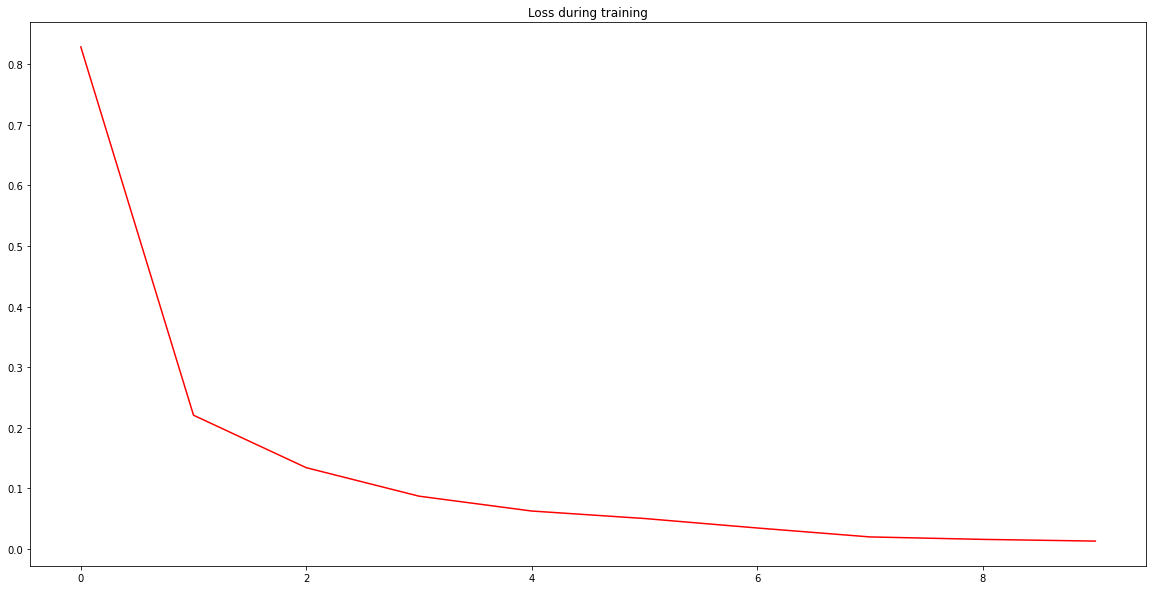

In [15]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(len(lossList)), lossList, color='red')
plt.title("Loss during training")
plt.show()

In [16]:
def show_image(reconsPath):
  Image = mpimg.imread(reconsPath)
  plt.imshow(Image) 
  plt.axis('off') 
  plt.show()

#### Incorrectly predicted images

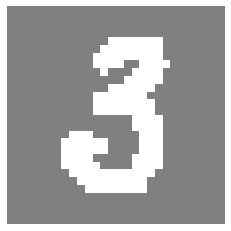

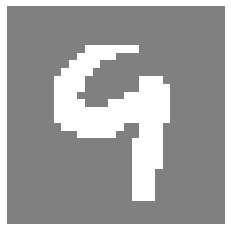

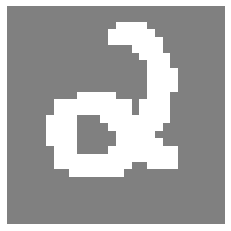

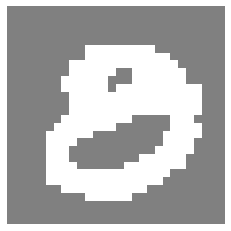

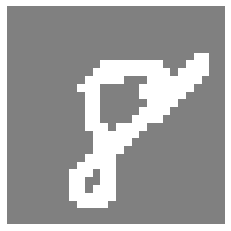

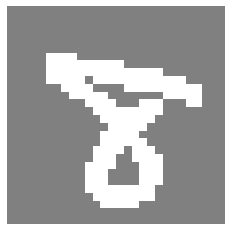

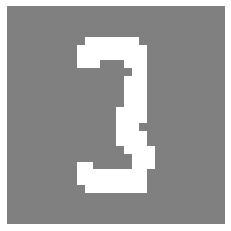

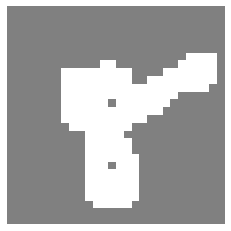

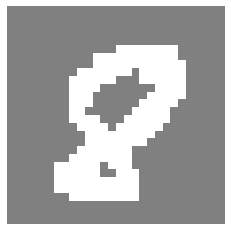

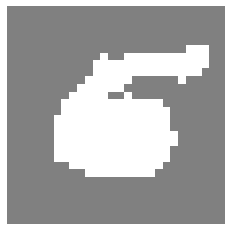

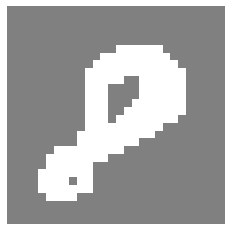

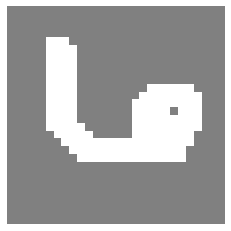

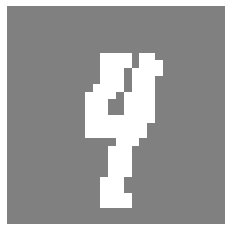

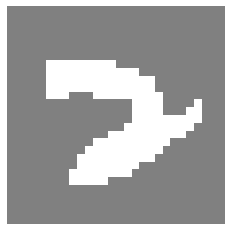

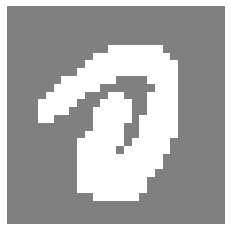

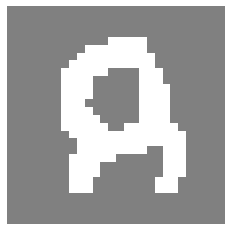

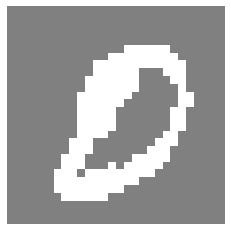

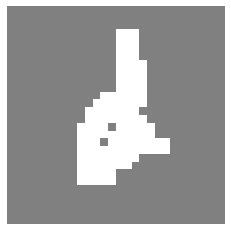

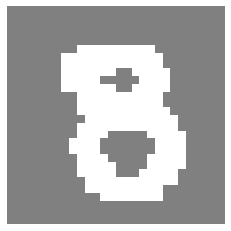

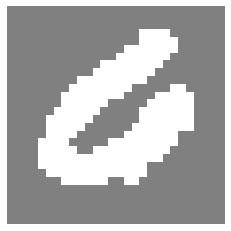

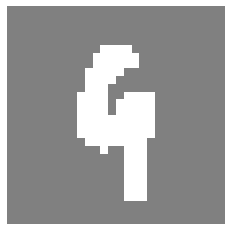

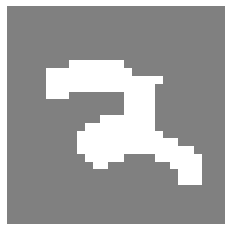

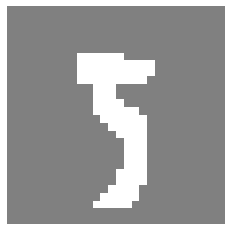

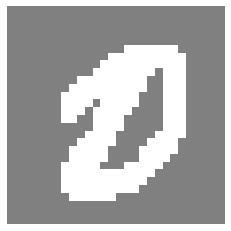

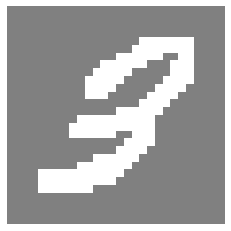

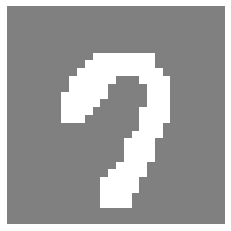

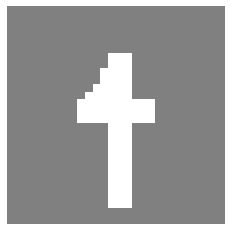

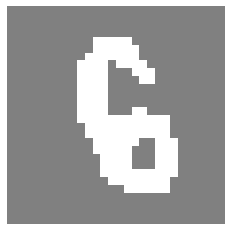

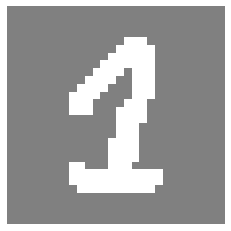

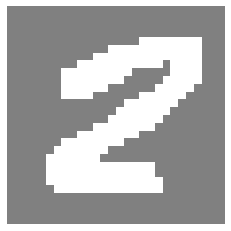

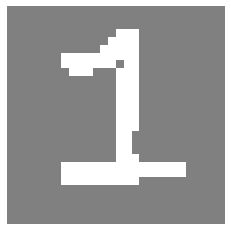

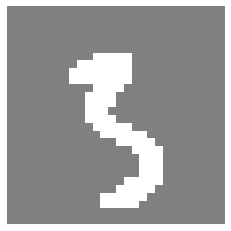

In [17]:
path = "./samples"
fileNumber = len([lists for lists in os.listdir(path) if os.path.isfile(os.path.join(path, lists))])

for i in range(1, fileNumber + 1):
  show_image("./samples/sampled-{}.png".format(i))

In [18]:
prediction = model((torch.from_numpy(test_x)).to(device).view(-1,784)).cpu().detach().numpy().argmax(axis=1)

In [19]:
print(prediction)

[9 7 3 ... 4 4 0]


In [21]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)